In [1]:
#imports
import pandas as pd

In [2]:
#read in the raw csv file
crime_data = pd.read_csv("../data/cleaned_data.csv", encoding= 'utf-8')
crime_data.head(2) #check to ensure it worked

,CrimeDate,CrimeTime,CrimeCode,Location,Description,InsideOutside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location1,Premise,vri_name1,TotalIncidents
0,9/5/20,1:30:00,6G,800 PONTIAC AVE,LARCENY,Inside,None,913.0,SOUTHERN,BROOKLYN,-76.598564,39.233880,NaN,ROW/TOWNHOUSE-OCC,Brooklyn,1
1,9/5/20,19:57:00,4E,4900 GUNTHER AVE,COMMON ASSAULT,Inside,None,443.0,NORTHEAST,FRANKFORD,-76.549157,39.327377,NaN,ROW/TOWNHOUSE-OCC,NaN,1


<AxesSubplot:title={'center':'Crimes per Day'}, xlabel='Day of Week', ylabel='# Of Crimes'>

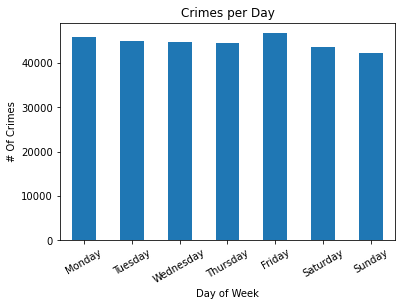

In [3]:
#Now lets start exploring the data!
#first lets do some analysis on what effect the CrimeTime has on the level of crimes
#We need to convert the date from object to datetime64 to do more analysis on it
crime_data["CrimeDate"] = crime_data["CrimeDate"].astype("datetime64")
crime_data["CrimeTime"] = crime_data["CrimeTime"].astype("datetime64")

#Certain time of day crimes are more likely/common?
crime_data["CrimeTime"].groupby(crime_data["CrimeTime"].dt.hour).count().plot(kind="bar", title="Crimes per Hour", ylabel="# Of Crimes", xlabel="Hour")

#Certain months crimes are more likely/common?
crime_data["CrimeDate"].groupby(crime_data["CrimeDate"].dt.month).count().plot(kind="bar", title="Crimes per Month", ylabel="# Of Crimes", xlabel="Month", rot=30)

#Certain day of the week crimes are more likely/common?
day_of_week_df = crime_data["CrimeDate"].groupby(crime_data["CrimeDate"].dt.dayofweek).count()
day_of_week_df.index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_of_week_df.plot(kind="bar", title="Crimes per Day", ylabel="# Of Crimes", xlabel="Day of Week", rot=30)

In [4]:
#Let's create a function that creates the df with counts to avoid code duplication:
def create_counts_df(group_x_axis, group_y_axis):
    counts_df = None #initialize here for scope
    if(group_x_axis == "CrimeDate"): #if looking at the date, look at the month
        counts_df = crime_data[group_x_axis].groupby([crime_data[group_x_axis].dt.month, crime_data[group_y_axis]]).count()
    elif(group_x_axis == "CrimeTime"): #if looking at the time, look at the hour
        counts_df = crime_data[group_x_axis].groupby([crime_data[group_x_axis].dt.hour, crime_data[group_y_axis]]).count()
    else: #otherwise, just use the value in the data
        counts_df = crime_data[group_x_axis].groupby([crime_data[group_x_axis], crime_data[group_y_axis]]).count()
    counts_df = counts_df.to_frame()
    counts_df.columns = ["Count"]
    counts_df = counts_df.reset_index()
    return counts_df

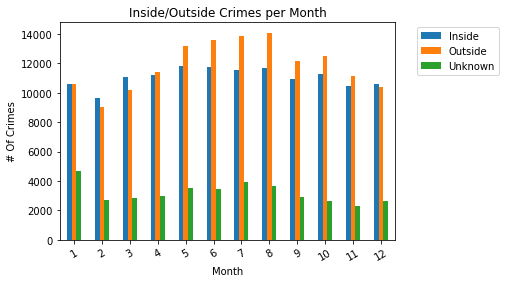

In [5]:
#Great, now lets see if there are patterns for inside/outside based on month of year
month_df = create_counts_df("CrimeDate", "InsideOutside")

ax = month_df.pivot(index='CrimeDate', columns='InsideOutside').plot(kind='bar', title="Inside/Outside Crimes per Month", ylabel="# Of Crimes", xlabel="Month", rot=30)
patches, labels = ax.get_legend_handles_labels()
labels = ['Inside', 'Outside', 'Unknown']
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')

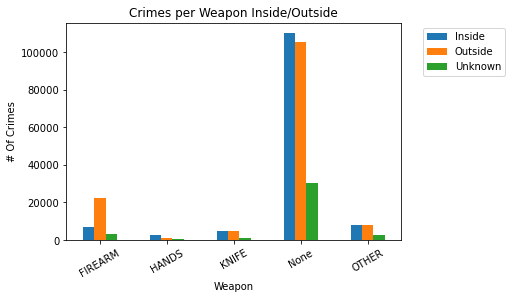

In [6]:
#Lets see if there are patterns for weapon based on inside/outside
weapon_I_O_df = create_counts_df("Weapon", "InsideOutside")

ax = weapon_I_O_df.pivot(index='Weapon', columns='InsideOutside').plot(kind='bar', title="Crimes per Weapon Inside/Outside", ylabel="# Of Crimes", xlabel="Weapon", rot=30)
patches, labels = ax.get_legend_handles_labels()
labels = ['Inside', 'Outside', 'Unknown']
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')

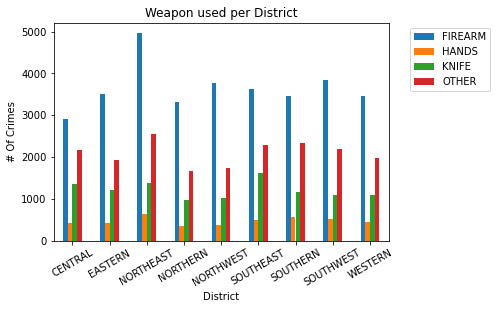

In [7]:
#Lets see if there are patterns for weapon based on District
weapon_district_df = create_counts_df("District", "Weapon")
#First tried with including 'None' but too many are 'None' to see the other distributions
weapon_district_df = weapon_district_df[weapon_district_df.Weapon != 'None']

ax = weapon_district_df.pivot(index='District', columns='Weapon').plot(kind='bar', title="Weapon used per District", ylabel="# Of Crimes", xlabel="District", rot=30)
patches, labels = ax.get_legend_handles_labels()
labels = ['FIREARM', 'HANDS', 'KNIFE', 'OTHER']
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')

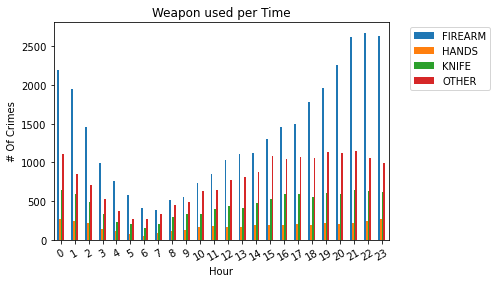

In [8]:
#Lets see if there are patterns for weapon based on time
weapon_time_df = create_counts_df("CrimeTime", "Weapon")
#First tried with including 'None' but too many are 'None' to see the other distributions
weapon_time_df = weapon_time_df[weapon_time_df.Weapon != 'None']

ax = weapon_time_df.pivot(index='CrimeTime', columns='Weapon').plot(kind='bar', title="Weapon used per Time", ylabel="# Of Crimes", xlabel="Hour", rot=30)
patches, labels = ax.get_legend_handles_labels()
labels = ['FIREARM', 'HANDS', 'KNIFE', 'OTHER']
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')

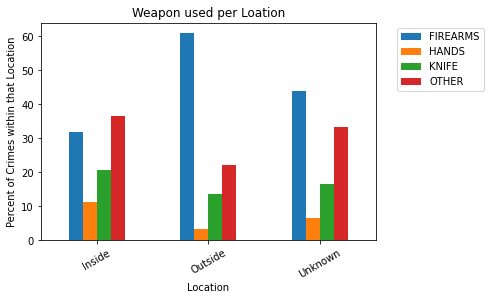

In [9]:
#Lets see if there are patterns for weapon based on InsideOutside
I_O_weapon_df = create_counts_df("InsideOutside", "Weapon")
#First tried with including 'None' but too many are 'None' to see the other distributions
I_O_weapon_df = I_O_weapon_df[I_O_weapon_df.Weapon != 'None']

#get some percentages, counts are less relevant, given inside/oustide what pct of crimes use that weapon?
#of the crimes that happen inside:
sum_outside = I_O_weapon_df[I_O_weapon_df.InsideOutside == 'Outside']['Count'].sum()
sum_inside = I_O_weapon_df[I_O_weapon_df.InsideOutside == 'Inside']['Count'].sum()
sum_unknown = I_O_weapon_df[I_O_weapon_df.InsideOutside == 'Unknown']['Count'].sum()

def generate_pcts(I_O_weapon_df):
    pcts = []
    for index, row in I_O_weapon_df.iterrows():
        if(row['InsideOutside'] == "Inside"):
            pcts.append((row["Count"]/sum_inside)*100)
        elif(row['InsideOutside'] == "Outside"):
            pcts.append((row["Count"]/sum_outside)*100)
        else:
            pcts.append((row["Count"]/sum_unknown)*100)
    return pcts

I_O_weapon_df['pcts'] = generate_pcts(I_O_weapon_df)

ax = I_O_weapon_df.pivot(index='InsideOutside', columns='Weapon', values='pcts').plot(kind='bar', title="Weapon used per Loation", ylabel="Percent of Crimes within that Location", xlabel="Location", rot=30)
patches, labels = ax.get_legend_handles_labels()
labels = ['FIREARMS', 'HANDS', 'KNIFE', 'OTHER']
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')

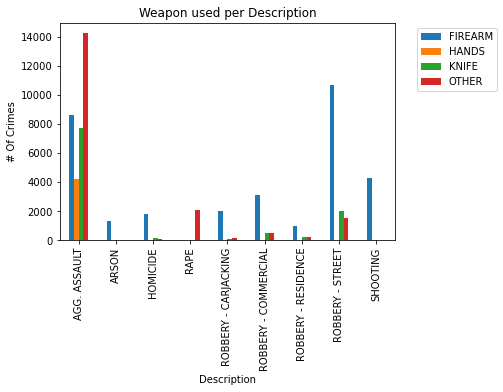

In [10]:
#Lets see if there are patterns for weapon based on description
description_weapon_df = create_counts_df("Description", "Weapon")
#First tried with including 'None' but too many are 'None' to see the other distributions
description_weapon_df = description_weapon_df[description_weapon_df.Weapon != 'None']

ax = description_weapon_df.pivot(index='Description', columns='Weapon').plot(kind='bar', title="Weapon used per Description", ylabel="# Of Crimes", xlabel="Description", rot=90)
patches, labels = ax.get_legend_handles_labels()
labels = ['FIREARM', 'HANDS', 'KNIFE', 'OTHER']
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')

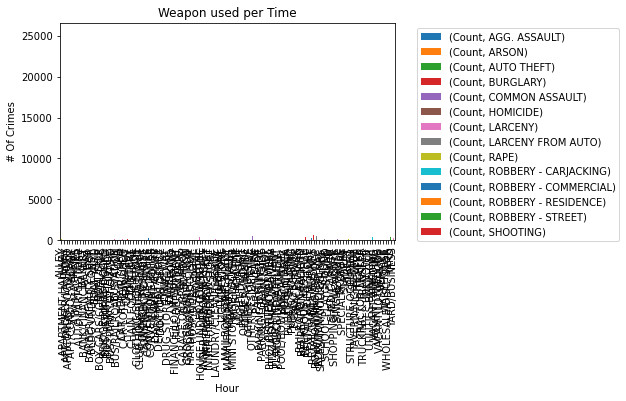

In [11]:
#Lets see if there are patterns for the crime description based on the premise
description_weapon_df = create_counts_df("Premise", "Description")

#This one is hard to visualize because there are so many different unique premises.  The visualizaiton is useless
#but the information gained from the dataframe may be useful


#Below are some attempts to get the percentage of the descripted crime given a premise
#description_weapon_df['Percentage'] = 100 * description_weapon_df['Title']  / description_weapon_df['Title'].sum()
#description_weapon_df['total'] = description_weapon_df.loc[description_weapon_df['Premise'] == 'ALLEY',['Count']].sum()
#print(description_weapon_df.loc[description_weapon_df['Premise'] == 'ALLEY',['Count']].sum())
#print(description_weapon_df)

ax = description_weapon_df.pivot(index='Premise', columns='Description').plot(kind='bar', title="Weapon used per Time", ylabel="# Of Crimes", xlabel="Hour", rot=90)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1.0), loc='upper left')